In [71]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf
from tensorflow.keras import layers
import os.path
import cv2 as cv

# https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

c:\Users\abarb\Documents\GitHub\abdomen_segmentation


In [72]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for i in range(5, min(len(img), 60), 10):
        disp_list.append(img[i])
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s) + 1E-7, -1, 1)

In [73]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    global raw_data
    global labeled_data
    
    for i in range(scan.shape[2]):

        if labeled_scan[:, :, i].sum() == 0:
            continue

        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[5:resized_data.shape[0]-5, 29:resized_data.shape[1]-29]
        resized_data_labeled = resized_data_labeled[5:resized_data_labeled.shape[0]-5, 29:resized_data_labeled.shape[1]-29]

        resized_data = normalize(resized_data)
        mask_img = np.where(resized_data > -1, 1, 0)
        resized_data_labeled = np.expand_dims(resized_data_labeled, axis=2)
        resized_data = np.expand_dims(resized_data, axis=2)
        mask_img = np.expand_dims(mask_img, axis=2)
        resized_data = np.append(resized_data, mask_img, axis=2)

        raw_data.append(resized_data)
        labeled_data.append(resized_data_labeled)

False
False
Data shape  : (2229, 160, 112, 2)
Label shape : (2229, 160, 112, 1)
Raw data type     : <dtype: 'float32'>
Labeled data type : <dtype: 'uint8'>
[0. 1.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


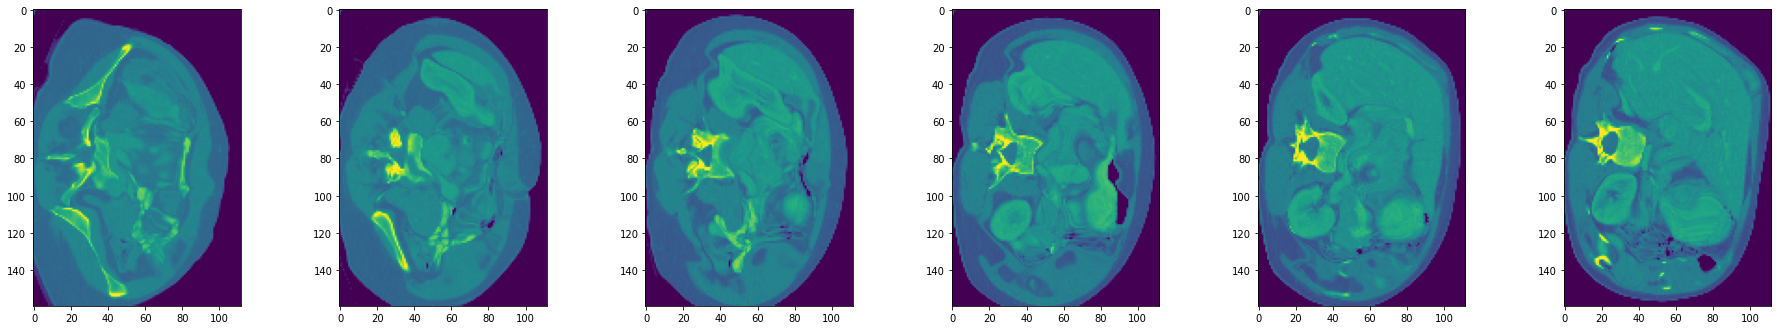

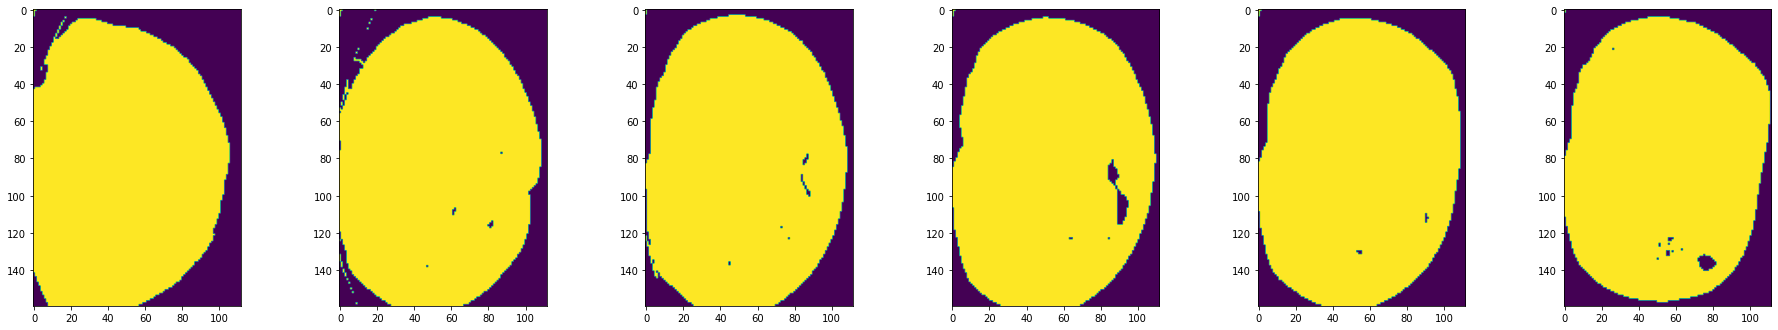

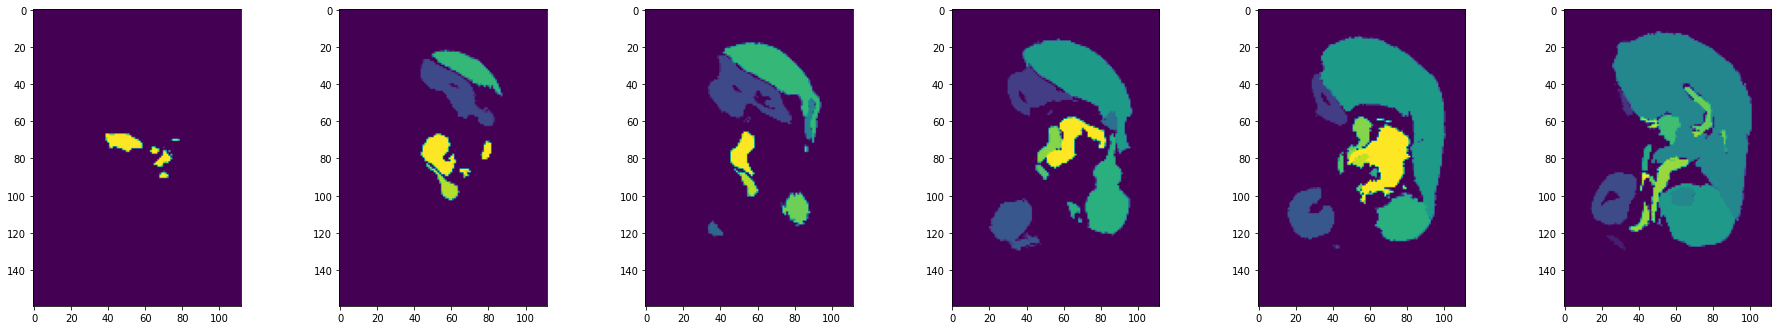

In [74]:
# if true, reload and process data again, else load the data saved previously in files stored in numpy_arrays
RELOAD_DATA = True

if RELOAD_DATA:
    # On a 30 * 30 abdomens + 20 * 30 labelisés au total, on doit les séparer en train, validation, test
    nb_dirs_to_load = 100
    nb_files_to_load_per_dir = 1 # putting a number bigger than the number of files will just loads every file in the folder

    loaded_dirs = 0
    for _, dirs, filenames in os.walk("./data/Training-Training/img"):
        for dir in dirs:

            loaded_dirs += 1
            if loaded_dirs > nb_dirs_to_load:
                break
            
            loaded_files = 0
            for _, dirs2, filenames2 in os.walk("./data/Training-Training/img/" + dir):
                for filename in filenames2:
                    if filename[0] == '.':
                        continue
                    
                    loaded_files += 1
                    if loaded_files > nb_files_to_load_per_dir:
                        break
                    
                    name = "./data/Training-Training/img/" + dir + "/" + filename
                    data = nib.load(name).get_fdata()
                    name_label = "./data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                    data_label = nib.load(name_label).get_fdata()
                    clean_and_save_data(data, data_label)

    raw_data = np.array(raw_data)
    labeled_data = np.array(labeled_data)
    raw_data = raw_data.astype('float32')
    labeled_data = labeled_data.astype('uint8')
    np.save("numpy_arrays/raw_data.npy", raw_data)
    np.save("numpy_arrays/labeled_data.npy", labeled_data)
else:
    raw_data = np.load("numpy_arrays/raw_data.npy")
    labeled_data = np.load("numpy_arrays/labeled_data.npy")

print(np.isnan(np.min(raw_data)))     # check for nan values
print(np.isnan(np.min(labeled_data))) # check for nan values

raw_data = tf.convert_to_tensor(raw_data, np.float32)
labeled_data = tf.convert_to_tensor(labeled_data, np.uint8)

print("Data shape  : " + str(raw_data.shape))
print("Label shape : " + str(labeled_data.shape))
print('Raw data type     :', raw_data.dtype)
print('Labeled data type :', labeled_data.dtype)
print(np.unique(raw_data[:, :, :, 1]))
print(np.unique(labeled_data))
print_slices(raw_data[:, :, :, 0])
print_slices(raw_data[:, :, :, 1])
print_slices(labeled_data)

In [75]:
# ---- UNET classique ----

_, sx, sy, sz = raw_data.shape

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def unet(input_size=(sx, sy, 2)):
    # inputs
   inputs = layers.Input(shape=input_size)
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

model = unet(input_size=(sx, sy, 2))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), loss="sparse_categorical_crossentropy", metrics="accuracy")

xtrain shape      : (1783, 160, 112, 2)
ytrain shape      : (1783, 160, 112, 1)
xvalidation shape : (223, 160, 112, 2)
yvalidation shape : (223, 160, 112, 1)
xtest shape       : (223, 160, 112, 2)
ytest shape       : (223, 160, 112, 1)


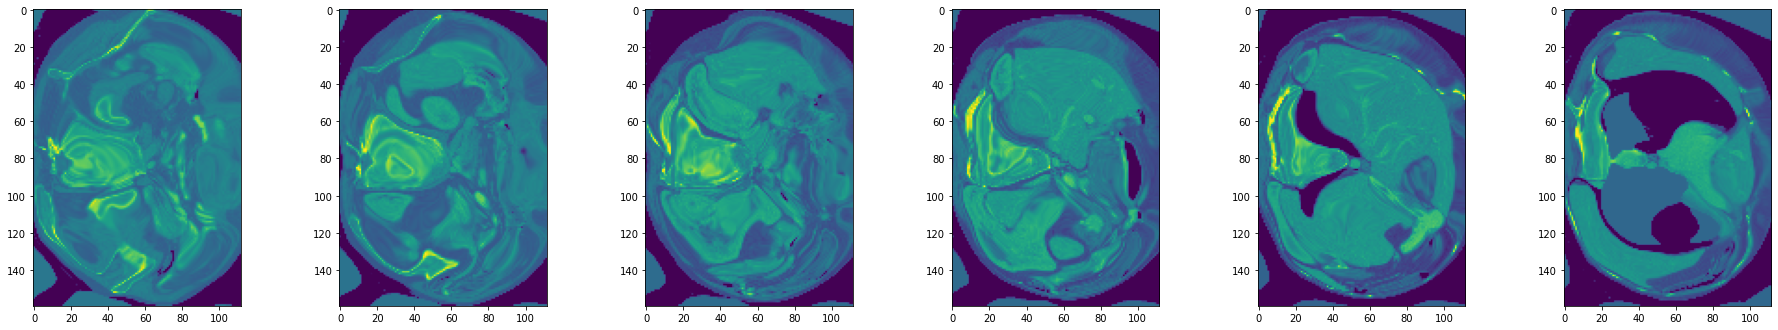

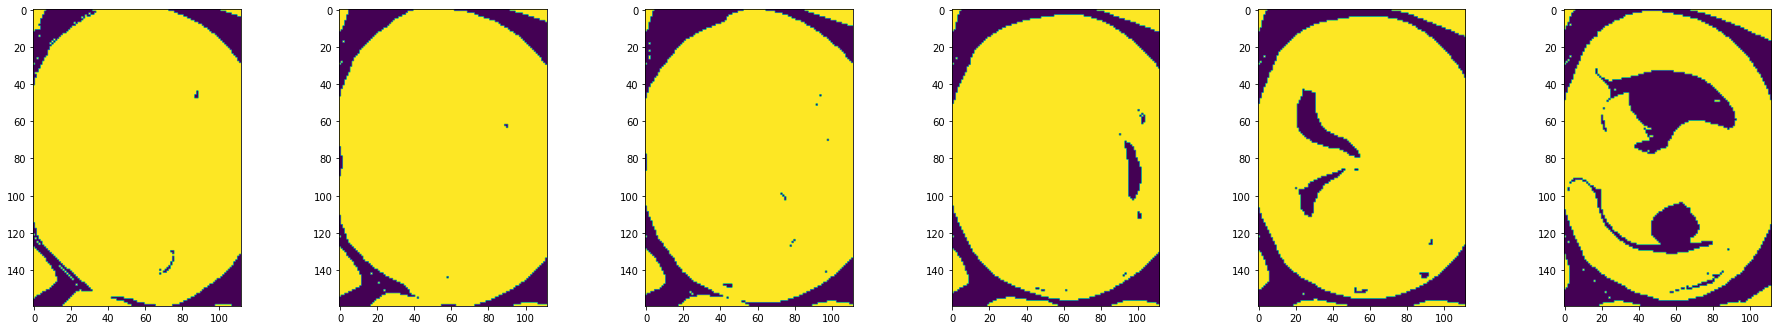

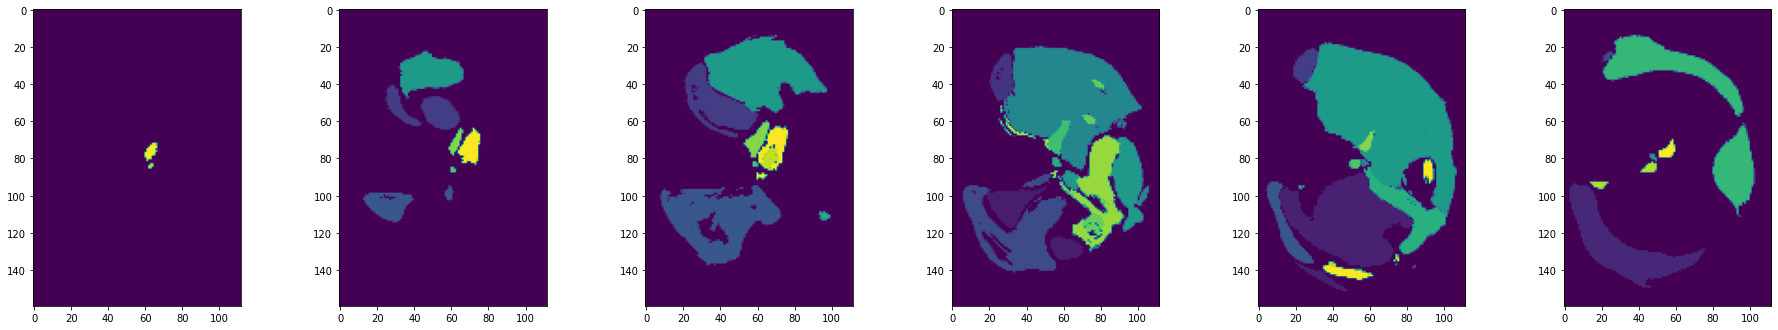

In [76]:
x, y = (0.8, 0.1) # split with x = 80%, y = 10% and therefore z = 10%
lenx = int(len(raw_data)*x)
leny = int(len(raw_data)*(x+y))

xtrain, xvalidation, xtest = np.split(raw_data, [lenx, leny])
ytrain, yvalidation, ytest = np.split(labeled_data, [lenx, leny])

print("xtrain shape      : " + str(xtrain.shape))
print("ytrain shape      : " + str(ytrain.shape))
print("xvalidation shape : " + str(xvalidation.shape))
print("yvalidation shape : " + str(yvalidation.shape))
print("xtest shape       : " + str(xtest.shape))
print("ytest shape       : " + str(ytest.shape))


print_slices(xtest[:, :, :, 0])
print_slices(xtest[:, :, :, 1])
print_slices(ytest)

In [77]:
# ---- entrainement ----

DO_WE_LEARN = True
epochs = 1
if DO_WE_LEARN:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 32,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model.save_weights("model.hdf5")
else:
    model.load_weights("model.hdf5")

56/56 [==============================] - 22s 374ms/step - loss: nan - accuracy: 0.8341 - val_loss: nan - val_accuracy: 0.8573


In [78]:
prediction = model.predict(xtest, verbose = 0)

(223, 160, 112, 1)
[nan]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


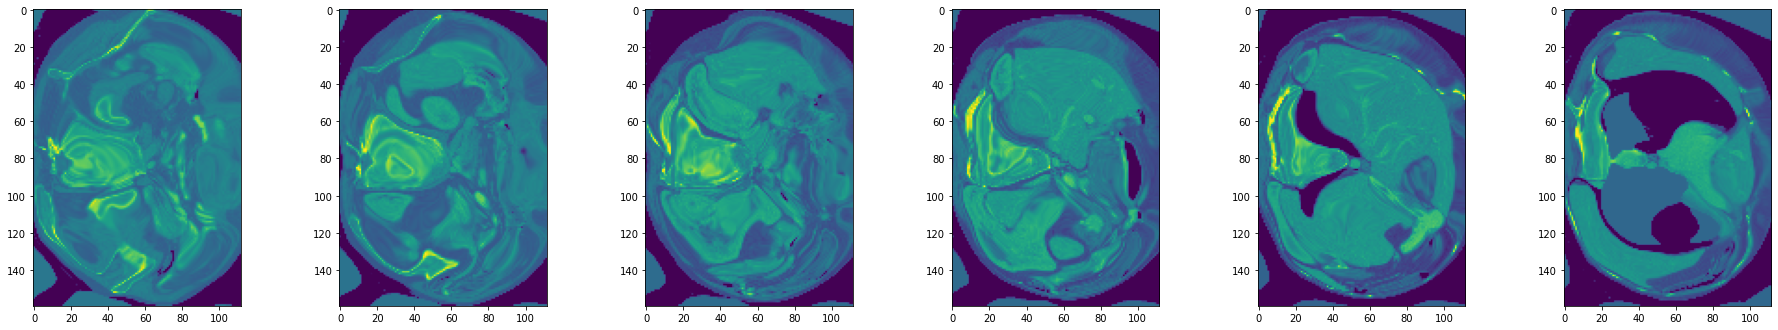

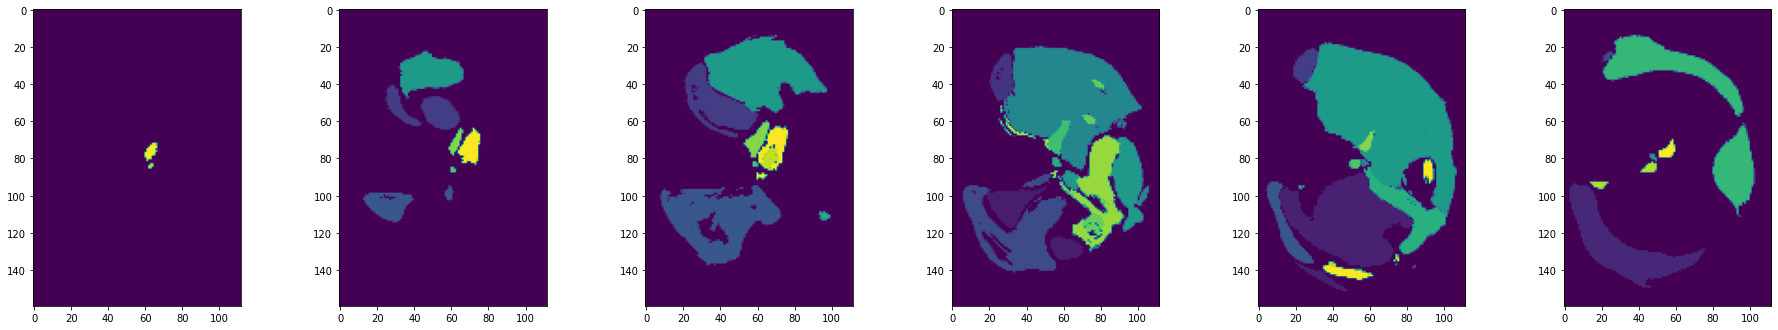

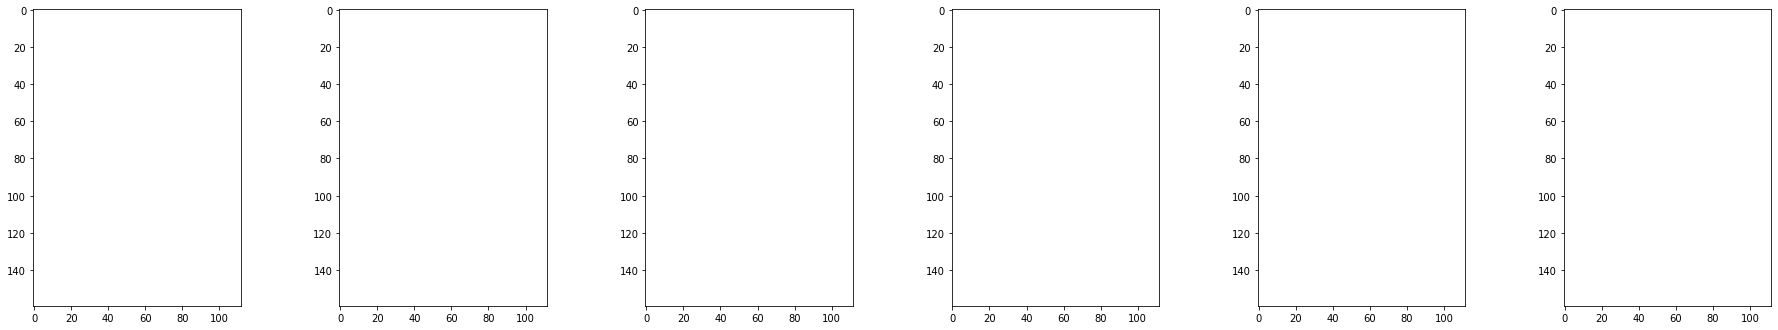

In [79]:
# print(compute_dice(xtest, ytest)) # pb ici
print(prediction.shape)
print(np.unique(prediction))
print(np.unique(ytest))
print_slices(xtest[:, :, :, 0])
print_slices(ytest)
print_slices(prediction)